##### Cargue de librerias

In [1]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import warnings
warnings.filterwarnings("ignore")

##### Conexion al DWH de Dispapeles y carga de bds adicionales

In [2]:
def df_clustering(consulta_SQL):
    ## Conexion al DWH
    cnxn = pyodbc.connect(
        driver='{SQL Server}',
        server='192.168.100.58',
        uid='bilectura',
        pwd='D1sp@p3l3s')
    cursor = cnxn.cursor()
    
    #Cargue de la data desde el ERP de Dispapeles y se guarda en df
    cursor.execute(consulta_SQL)
    rows = cursor.fetchall()
    
    df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

    return df
def min_max_scaler_custom_scale(df, col_name, min_scale= 1, max_scale= 24):
    df_copy = df.copy()  # Se crea una copia del DataFrame original
    x_min = df_copy[col_name].min()
    x_max = df_copy[col_name].max()
    col_norm = ((df_copy[col_name] - x_min) / (x_max - x_min)) * (max_scale - min_scale) + min_scale
    # col_norm = col_norm.apply(lambda x: round(x, 0))  # Redondeo a cero decimales después del punto
    df_copy[col_name] = col_norm  # Se asignan los valores normalizados a la columna Monetary
    return df_copy

In [3]:
# Consulta SQL para descargar la informacion a usar
codigo_SQL = "SELECT A.DSTCOD AS 'Codigo distrito', B.VNDZNA AS 'Codigo zona actual', CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC) AS 'Nit cliente-sucursal', A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', (((2021 - MAX(A.VTAANO)) * 12 ) + (0 - MAX(A.VTAMES))) * -1 AS 'Recency', SUM(A.VTAVLRVTA) AS 'Monetary', COUNT( DISTINCT A.VTAMES) AS 'Frequency' FROM V_VTA_VTAHEC A LEFT JOIN	DIM_CLIENTES B ON A.PRMCOD = B.PRMCOD AND A.DSTCOD = B.DSTCOD AND A.VTANIT = B.CLTNIT AND A.VTASUC = B.CLTSUC WHERE A.PRMCOD = 1 AND A.DSTCOD NOT IN (30,35) AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN '2021-01-01' AND '2022-12-31' GROUP BY A.DSTCOD, B.VNDZNA, CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC), A.VTAANO, A.VTAMES HAVING SUM(A.VTAVLRVTA) > 0"

# Consulta adicional para establecer el tipo de zona
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")

In [4]:
df = df_clustering(codigo_SQL)

##### Tranformaciones

In [5]:
# Conversion de tipo de la columna Monetary
df["Monetary"] = df["Monetary"].astype(int)

# Join con la maestra de zonas para determinar el tipo de zona
df_2 = pd.merge(df, maestra_zonas, on= ["Codigo distrito", "Codigo zona actual"])

# Filtro de la informacion para excluir zonas no relevantes
list_filter = ['Artes graficas', 'TIG', 'V Horeca', 'Institucional', 'V SyE',
                'V Industria', 'Mayorista']
df = df_2[df_2["Nombre tipo zona"].isin(list_filter)]

# DF final agregada por tipo de zona
df_3 = df.groupby(["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal"]).agg({"Recency": np.max,
                                                                            "Monetary": np.sum,
                                                                            "Frequency": np.sum
                                                                            })
df_3 = df_3.reset_index(col_level= 1)

In [6]:
# Se añade una key de Distrito-Nombretipozona para hacer mas facil la identificacion cuando se usa todo el pais
# Se genera la calificacion de Recency basado en los valores máximos
# Se divide por millón la columna Monetary para disminuir el rango de los valores
df_3['Distrito-Nombretipozona'] = df_3['Codigo distrito'].astype(str) + '-' + df_3['Nombre tipo zona']
df_3['Monetary'] = (df_3['Monetary'] / 1000).astype(int)
df_3['Frequency'] = (df_3['Frequency']).astype(int)

##### Creacion, ajuste y descarga de los modelos de clustering por cada distrito-tipo de zona

In [7]:
list_dtos = df_3["Distrito-Nombretipozona"].unique()
numeric_features = ["Recency", "Monetary", "Frequency"]
ignore_columns = ["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal", "Distrito-Nombretipozona"]
normalizar = [False, True]

#### EDA

In [8]:
def histograma(bd):
    fig, ax = plt.subplots(1, 3, figsize= (15,5))

    sns.kdeplot(bd['Recency'], ax= ax[0], color= 'blue', fill= True)
    sns.kdeplot(bd['Frequency'], ax= ax[1], color= 'red', fill= True)
    sns.kdeplot(bd['Monetary'], ax= ax[2], color= 'yellow', fill= True)
    fig.suptitle("Distribuciones del modelo RFM")
    plt.show()

def scatter(bd):
    fig, ax = plt.subplots(1, 1, figsize= (8,5))

    sns.scatterplot(x= 'Recency', size= 'Frequency', y= 'Monetary', data= bd)
    fig.suptitle("Scatter del modelo RFM")
    plt.show()

def EDA(bd):
    
    print(f"Esta base de datos tiene {len(bd)} registros,")
    print(f"hace parte del distrito {bd['Codigo distrito'][0]}")
    print(f"y el tipo de zona es {bd['Nombre tipo zona'][0]}")
    
    print(" ")
    print("Describe de la base de datos")
    describe = bd.describe().applymap("{:,.0f}".format)
    print(describe[['Recency', 'Frequency', 'Monetary']][1:])
    
    print(" ")
    
    # Variables auxiliares
    max = bd['Monetary'].max()
    min = bd['Monetary'].min()
    rango = max - min
    # mean = 
    # sd =
        
    print(f"El valor máx del campo Monetary es: {max:,.0f}")
    print(f"y el valor min es: {min:,.0f}")
    print(f"por lo tanto su rango es de: {rango:,.0f}")

    histograma(bd)
    scatter(bd)

In [9]:
df_EDA = df_3[df_3["Distrito-Nombretipozona"] == '10-Artes graficas']

Esta base de datos tiene 523 registros,
hace parte del distrito 10
y el tipo de zona es Artes graficas
 
Describe de la base de datos
     Recency Frequency   Monetary
mean      19         9    167,539
std        7         8    417,035
min        1         1         78
25%       17         2      4,166
50%       23         7     28,374
75%       24        16    135,644
max       24        24  4,608,290
 
El valor máx del campo Monetary es: 4,608,290
y el valor min es: 78
por lo tanto su rango es de: 4,608,212


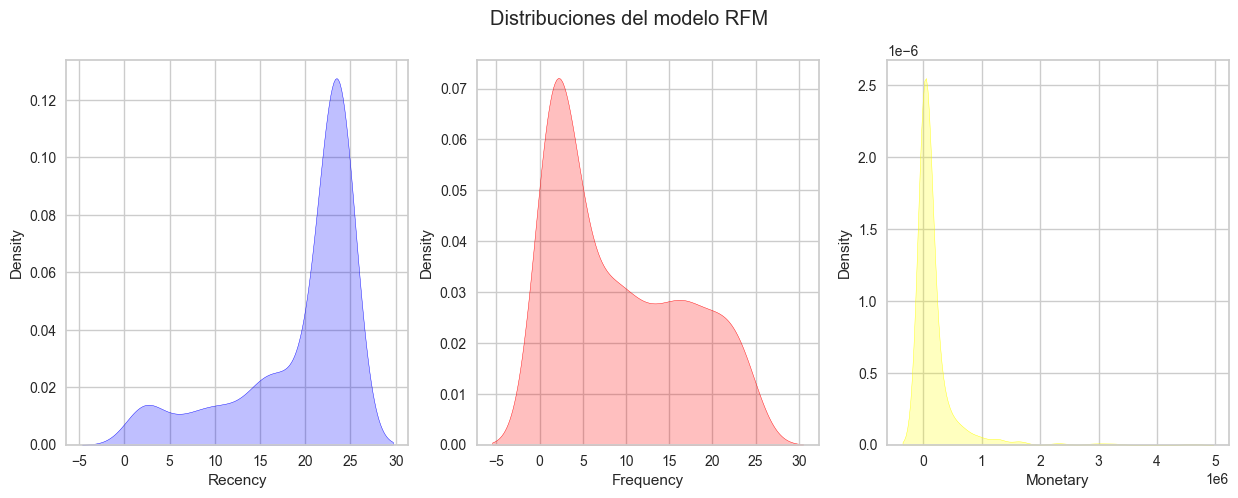

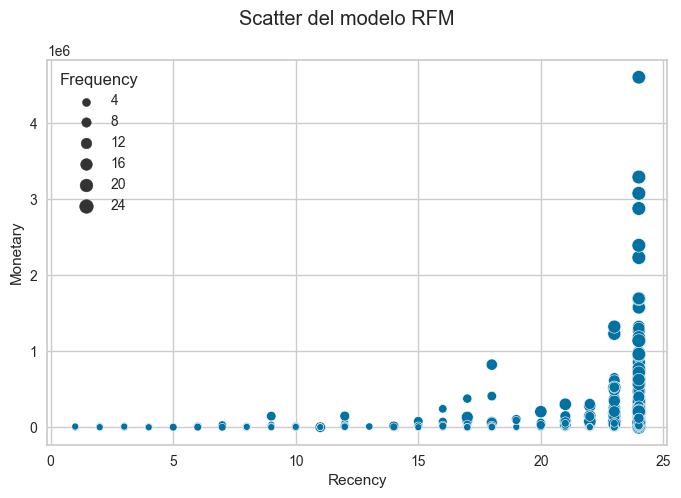

In [10]:
EDA(df_EDA)

##### Dos modelos, norm= True y norm= False

In [11]:
# Variables iniciales
bd_predicted = pd.DataFrame([])
metrics = []

# Fecha para guardar resultados
fecha = '22-03-23'

# Ciclo para realizar el modelo de clustering por cada tipo de zona del pais
for norm in normalizar:
    for n, dto in enumerate(list_dtos):
        print(f"Procesando modelo normalizado {norm} {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
        
        #BD filtrada
        df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
        
        if norm:
            df_dto = min_max_scaler_custom_scale(df_dto, "Monetary")
        else:
            df_dto

        #Setup del modelo 
        s = setup(
                    df_dto,
                    verbose= False,
                    preprocess= False,
                    silent= True,
                    profile= False,
                    ignore_features= ignore_columns,
                    numeric_features= numeric_features
                    )
        
        #Creacion y prediccion de modelo
        model_kmeans = create_model(
                                    'kmeans',
                                    num_clusters= 5,
                                    verbose= False,
                                    )
        pull()
        df_pred_km = predict_model(
                                    model_kmeans,
                                    data = df_dto
                                    )
        
        # Reasignacion de los nombres de los clusters
        trans = df_pred_km.groupby(
                                    ["Cluster"]).agg({
                                                    "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                    }).sort_values(
                                                                    by= ["Monetary", "Frequency", "Recency"],
                                                                    ascending= False
                                                                    ).reset_index()
        trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
        trans = trans[["Cluster", "Letra cluster"]]
        
        df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
        
        # Descarga del modelo
        bd_predicted = bd_predicted.append(df_pred_km)

        #Append a la variable incial de metricas
        metrics.append({
                        "Distrito-zona": dto,
                        "Normalizado": norm,
                        "Silhouette": pull().Silhouette[0],
                        "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                        "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                        })
        # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

# Transformacion de la variable de metricas
metrics = pd.DataFrame(metrics)
metrics["Normalizado"] = metrics["Normalizado"].replace([True, False], ["Si","No"])
metrics["Tipo zona"] = metrics["Distrito-zona"].str[3:]

print("Proceso completo 100%")

Procesando modelo normalizado False 1 de 67. 1.5%
Procesando modelo normalizado False 2 de 67. 3.0%
Procesando modelo normalizado False 3 de 67. 4.5%
Procesando modelo normalizado False 4 de 67. 6.0%
Procesando modelo normalizado False 5 de 67. 7.5%
Procesando modelo normalizado False 6 de 67. 9.0%
Procesando modelo normalizado False 7 de 67. 10.4%
Procesando modelo normalizado False 8 de 67. 11.9%
Procesando modelo normalizado False 9 de 67. 13.4%
Procesando modelo normalizado False 10 de 67. 14.9%
Procesando modelo normalizado False 11 de 67. 16.4%
Procesando modelo normalizado False 12 de 67. 17.9%
Procesando modelo normalizado False 13 de 67. 19.4%
Procesando modelo normalizado False 14 de 67. 20.9%
Procesando modelo normalizado False 15 de 67. 22.4%
Procesando modelo normalizado False 16 de 67. 23.9%
Procesando modelo normalizado False 17 de 67. 25.4%
Procesando modelo normalizado False 18 de 67. 26.9%
Procesando modelo normalizado False 19 de 67. 28.4%
Procesando modelo normaliza

##### Visualizacion y validacion clustering

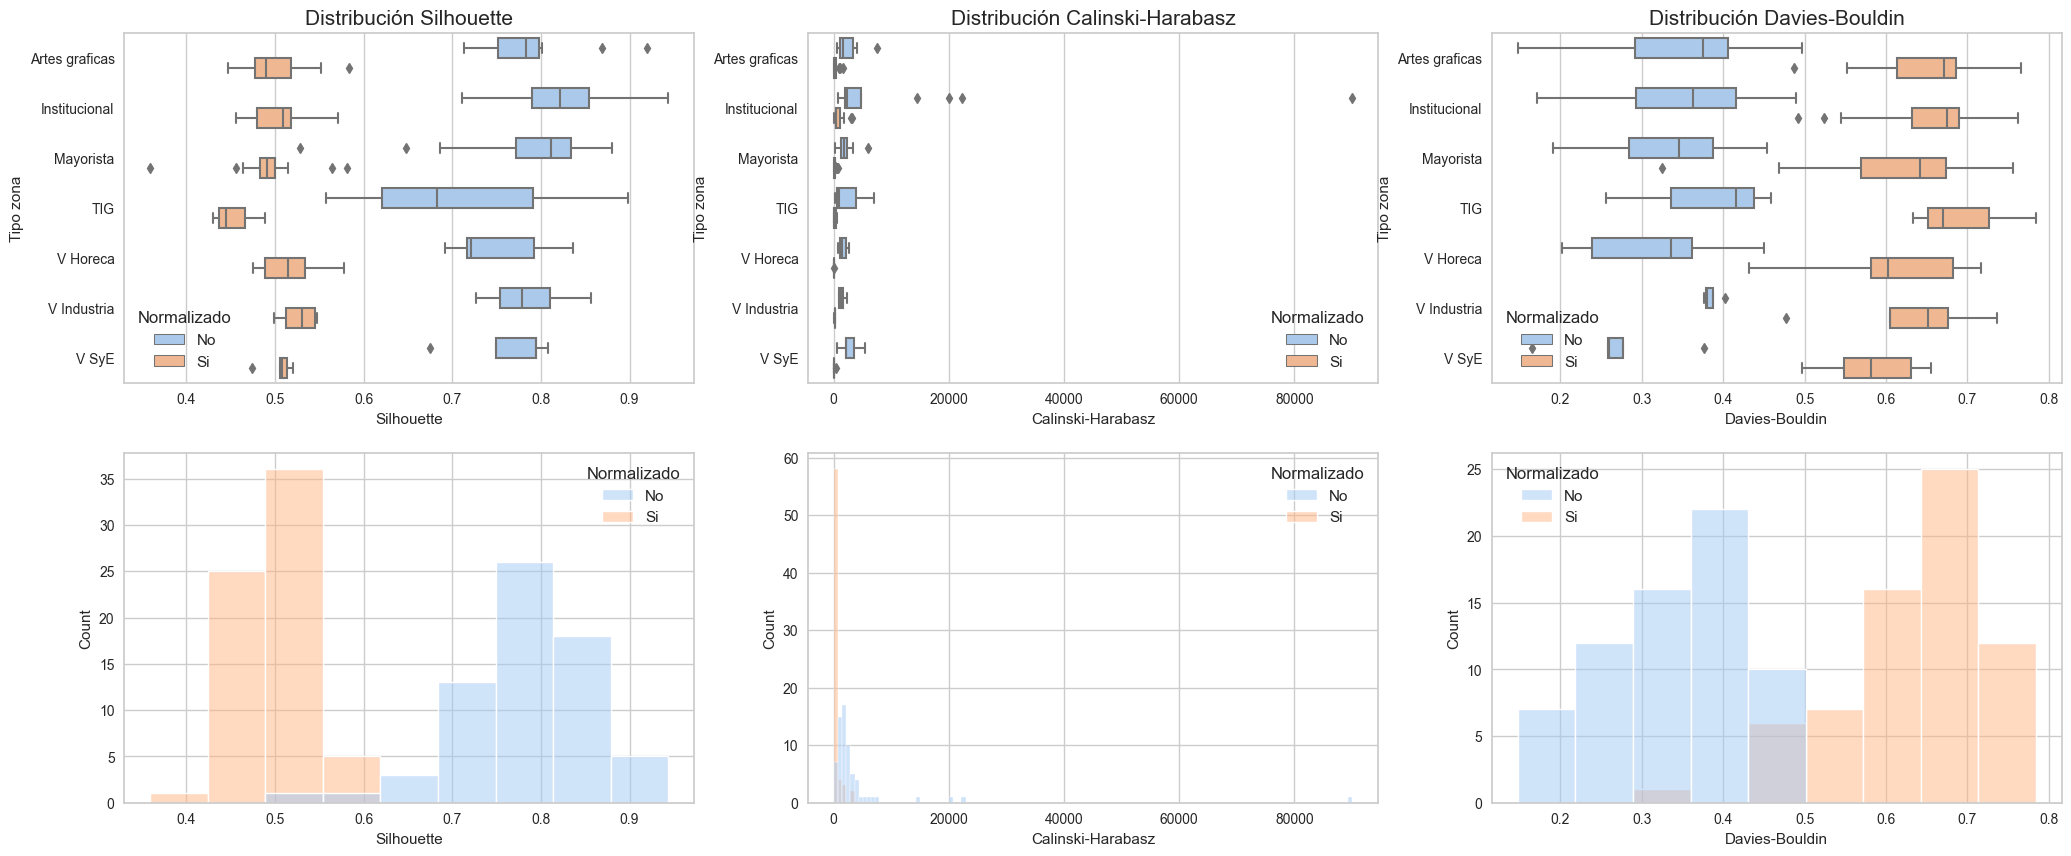

In [12]:
# Plots para validar si hay diferencia o no entre la data normalizada o no
f, axarr = plt.subplots(2,3)
f.set_figheight(10)
f.set_figwidth(25)

metricas = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]

for n, met in enumerate(metricas):
    f.add_subplot(axarr[0,n])
    plt.title(f"Distribución {met}").set_fontsize(15)
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.boxplot(data= metrics, x= met, y= "Tipo zona", hue= 'Normalizado')

    f.add_subplot(axarr[1,n])
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.histplot(data= metrics, x= met, hue= 'Normalizado')
plt.show()

In [13]:
# Describe de las metricas normalizadas
metrics[metrics['Normalizado'] == "Si"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.500240,444.454440,0.636313
std,0.037866,597.450252,0.087968
min,0.359100,59.651700,0.324500
25%,0.478600,130.941050,0.600450
50%,0.499100,233.643700,0.655900
75%,0.517600,451.169950,0.685500
max,0.583000,3202.660700,0.784200


In [14]:
# Describe de las metricas NO normalizadas
metrics[metrics['Normalizado'] == "No"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.784687,4252.983148,0.339915
std,0.074056,11314.921284,0.086010
min,0.528600,233.687700,0.147600
25%,0.741300,1257.484650,0.280250
50%,0.794600,2011.514200,0.357900
75%,0.831800,3165.974150,0.398100
max,0.943700,90015.186400,0.496900


In [15]:
# Descarga de bd predicha y metricas calculadas
bd_predicted.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",", sep= ";")
metrics.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Metricas {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",",  sep= ";")

In [16]:
df_pred_km

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency,Distrito-Nombretipozona,Cluster,Letra cluster
0,90,Mayorista,1007934252-1,14,1.019305,5,90-Mayorista,Cluster 4,D
1,90,Mayorista,10091164-1,17,1.096318,1,90-Mayorista,Cluster 4,D
2,90,Mayorista,1070594547-1,13,1.343987,4,90-Mayorista,Cluster 4,D
3,90,Mayorista,1105670924-1,13,1.028703,11,90-Mayorista,Cluster 4,D
4,90,Mayorista,1105791853-1,15,1.006391,2,90-Mayorista,Cluster 4,D
...,...,...,...,...,...,...,...,...,...
131,90,Mayorista,901416140-1,24,1.702799,19,90-Mayorista,Cluster 2,B
132,90,Mayorista,93370623-1,24,1.184497,23,90-Mayorista,Cluster 2,B
133,90,Mayorista,93386132-1,22,7.824215,19,90-Mayorista,Cluster 2,B
134,90,Mayorista,93414007-1,24,1.170004,15,90-Mayorista,Cluster 2,B


Text(0.5, 0, 'Frequency')

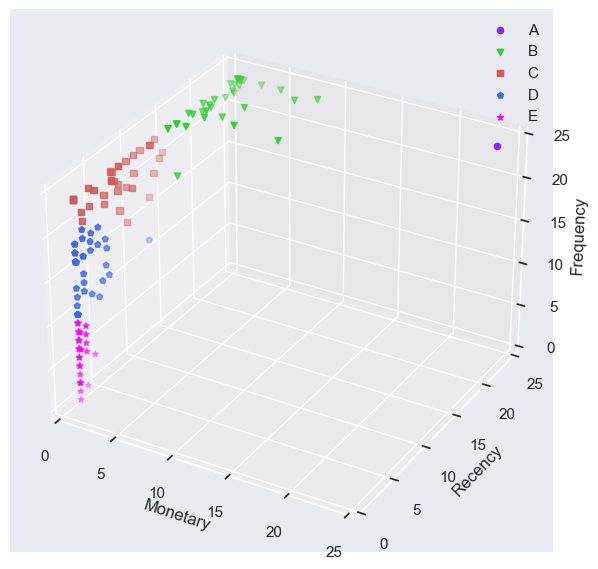

In [17]:
# Visualizacion de los clusters
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
# leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
leg = ['A', 'B', 'C', 'D', 'E']
cluster = list(np.unique(df_pred_km['Letra cluster']))

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Letra cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'],df_plot['Frequency'], df_plot['Recency'] , marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [18]:
plot_model(model_kmeans, plot = 'cluster')

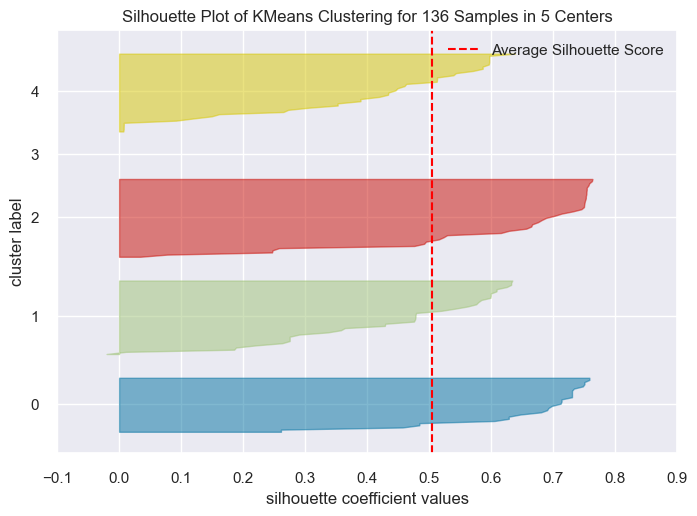

In [19]:
plot_model(model_kmeans, plot = 'silhouette')

In [20]:
plot_model(model_kmeans, plot = 'distribution')